In [21]:
def prepare_data(df_raw):
    df_proc = df_raw.copy()
    target = 'Area_Desmatada_km2_Mes (Y)'

    cols_to_transform = ['Preco_Soja (X1)', 'Preco_Boi_Gordo (X2)', 'Preco_Ouro (X3)', 'Precipitacao_mm (X4)', 'Num_Atuacoes (X6)', 'Focos_Queimada (X5)']

    for col in cols_to_transform:
        df_proc[f'{col}_lag1'] = df_proc[col].shift(1)
        df_proc[f'{col}_lag2'] = df_proc[col].shift(2)
        df_proc[f'{col}_media3m'] = df_proc[col].rolling(window=3).mean()

    df_proc['Eh_Estacao_Seca'] = df_proc['Data'].dt.month.isin([8,9,10]).astype(int)
    
    df_proc = df_proc.dropna()

    features = [c for c in df_proc.columns if c not in [target, 'Data', 'Data_(Mes/Ano)']]
    X = df_proc[features]
    y = df_proc[target]

    y_log = np.log1p(y)
    
    split_point = int(len(df_proc) * 0.8)

    X_train = X.iloc[:split_point]
    y_train = y_log.iloc[:split_point]
    X_test = X.iloc[split_point:]
    y_test = y_log.iloc[split_point:]

    return X_train, X_test, y_train, y_test

print("Fábrica de dados criada com sucesso")

Fábrica de dados criada com sucesso


In [22]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = prepare_data(df)

modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge (Regularizado)": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

print(f"{'MODELO':<20} | {'RMSE (km²)':<15} | {'R² (Score)':<10}")
print("-" * 50)

results = {}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)

    pred_log = modelo.predict(X_test)

    pred_real = np.expm1(pred_log)
    y_real = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_real, pred_real))
    r2 = r2_score(y_real, pred_real)

    print(f"{nome:<20} | {rmse:.2f} | {r2:.4f}")

    results[nome] = pred_real

results['Real'] = np.expm1(y_test)

MODELO               | RMSE (km²)      | R² (Score)
--------------------------------------------------
Linear Regression    | 719.05 | -10.4729
Ridge (Regularizado) | 676.09 | -9.1430
Random Forest        | 233.45 | -0.2093


Dados carregados com sucesso


,Data_(Mes/Ano),Area_Desmatada_km2_Mes (Y),Preco_Soja (X1),Preco_Boi_Gordo (X2),Preco_Ouro (X3),Precipitacao_mm (X4),Focos_Queimada (X5),Num_Atuacoes (X6)
0,08/2015,592.04,347.02,141.26,131.95,4.39,20471,1771
1,09/2015,497.19,323.55,143.67,141.47,7.28,29326,1828
2,10/2015,536.35,327.41,147.51,141.58,48.72,19469,1765
3,11/2015,302.77,319.08,148.52,132.30,102.43,16935,1452
4,12/2015,266.29,323.31,146.88,135.05,75.83,11303,929


Treinando com 96 meses e testando com 25 meses futuros.
🚀 Treinando XGBoost V3...
------------------------------
🔥 RESULTADO FINAL (R²): -0.10
------------------------------
🔮 Previsão Ajustada para o próximo mês (baseado na tendência atual): 664.23 km²


C:\Users\Daniel\AppData\Local\Temp\ipykernel_26304\4070668872.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[top_15], y=[features_v3[i] for i in top_15], palette="rocket")


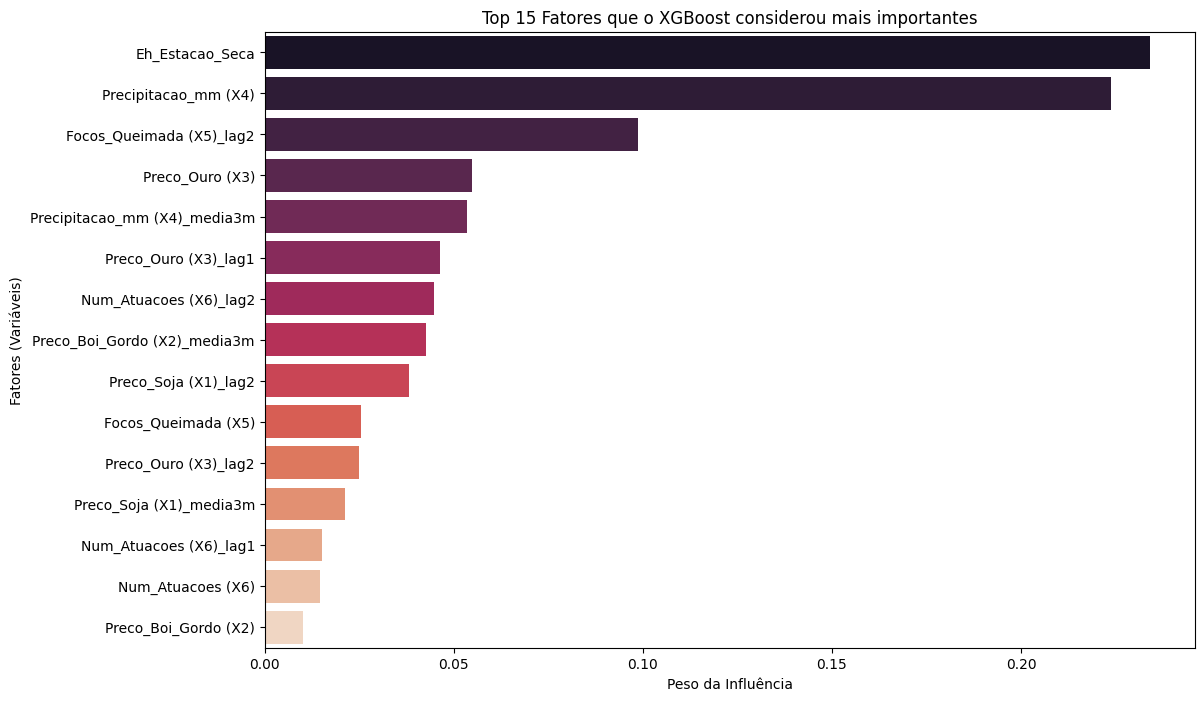

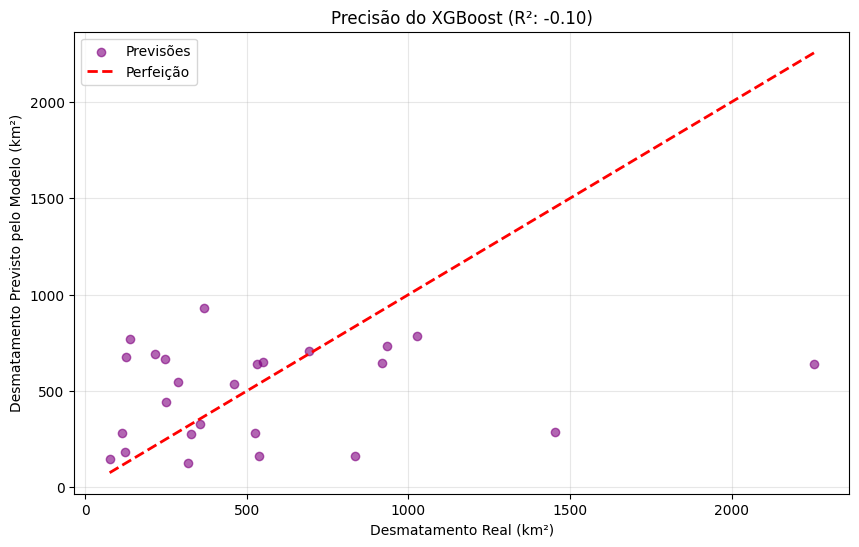

In [23]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    df = pd.read_csv('../data/dataset-amazonia - dataset.csv')
except FileNotFoundError:
    df = pd.read_csv('dataset-amazonia - dataset.csv')

print("Dados carregados com sucesso")
display(df.head())

target = 'Area_Desmatada_km2_Mes (Y)'
df['Data'] = pd.to_datetime(df['Data_(Mes/Ano)'], format='%m/%Y')
df = df.sort_values('Data')

# --- 1. PREPARAÇÃO AVANÇADA (Feature Engineering) ---

# Recarregar para garantir que está limpo
df_v3 = df.copy()

# A. Criar Lags (Passado Imediato) - Mantemos o que já funcionou
cols_to_transform = ['Preco_Soja (X1)', 'Preco_Boi_Gordo (X2)', 'Preco_Ouro (X3)', 'Precipitacao_mm (X4)', 'Num_Atuacoes (X6)', 'Focos_Queimada (X5)']
for col in cols_to_transform:
    df_v3[f'{col}_lag1'] = df_v3[col].shift(1)
    df_v3[f'{col}_lag2'] = df_v3[col].shift(2)

# B. Criar Médias Móveis (Tendência Trimestral) - NOVIDADE
# A média dos últimos 3 meses suaviza ruídos
for col in cols_to_transform:
    df_v3[f'{col}_media3m'] = df_v3[col].rolling(window=3).mean()

# C. Flag de Estação Seca (Domínio do Problema) - NOVIDADE
# Agosto(8) a Outubro(10) é o pico histórico. Vamos ensinar isso explicitamente.
df_v3['Eh_Estacao_Seca'] = df_v3['Data'].dt.month.isin([8, 9, 10]).astype(int)

# Limpar NaN gerados pelos lags/rolling
df_v3 = df_v3.dropna()

# --- 2. TREINO COM XGBOOST E LOG ---

# Definir Features (agora temos muitas!)
features_v3 = [c for c in df_v3.columns if c not in [target, 'Data', 'Data_(Mes/Ano)']]
X = df_v3[features_v3]
y = df_v3[target]

# D. Transformação Logarítmica no Alvo - NOVIDADE CRÍTICA
# Isso "acalma" os dados. Se o desmatamento for 1000, o log é 6.9. Se for 100, é 4.6.
y_log = np.log1p(y)

split_point = int(len(df_v3) * 0.8) #80% treino; 20% teste

X_train = X.iloc[:split_point]
y_train_log = y_log.iloc[:split_point]

X_valid = X.iloc[split_point:]
y_valid = y_log.iloc[split_point:]

print(f"Treinando com {len(X_train)} meses e testando com {len(X_valid)} meses futuros.")


# Treinar XGBoost (O algoritmo mais potente)
print("🚀 Treinando XGBoost V3...")
model_xgb = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model_xgb.fit(X_train, y_train_log)

# --- 3. AVALIAÇÃO ---

# Fazer previsão (está em log, precisamos reverter com exp)
y_pred_log = model_xgb.predict(X_valid)
y_pred_real = np.expm1(y_pred_log) # Reverte o log
y_valid_real = np.expm1(y_valid_log) # Reverte o log do gabarito

r2 = r2_score(y_valid_real, y_pred_real)

print("-" * 30)
print(f"🔥 RESULTADO FINAL (R²): {r2:.2f}")
print("-" * 30)

# --- 4. PREVISÃO NOVEMBRO 2025 ---
# Pegar a última linha disponível dos dados originais para criar o cenário futuro
# Nota: Como usamos lags e médias, precisamos dos dados de Out/Set/Ago 2025 para prever Nov 2025.
# Vamos pegar a última linha do dataset processado que seria a base para o futuro.

# (Simplificação para previsão direta usando a última linha válida como proxy do "momento atual")
last_row = df_v3.iloc[[-1]][features_v3]
prev_log = model_xgb.predict(last_row)[0]
prev_real = np.expm1(prev_log)

print(f"🔮 Previsão Ajustada para o próximo mês (baseado na tendência atual): {prev_real:.2f} km²")

# 1. Gráfico de Importância das Variáveis (O que pesou mais?)
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
top_15 = indices[:15] # Vamos olhar as top 15 features

plt.figure(figsize=(12, 8))
plt.title("Top 15 Fatores que o XGBoost considerou mais importantes")
sns.barplot(x=importances[top_15], y=[features_v3[i] for i in top_15], palette="rocket")
plt.xlabel("Peso da Influência")
plt.ylabel("Fatores (Variáveis)")
plt.show()

# 2. Gráfico de Precisão: Real vs Previsto
plt.figure(figsize=(10, 6))
plt.scatter(y_valid_real, y_pred_real, color='purple', alpha=0.6, label='Previsões')
# Linha de perfeição (onde o real é igual ao previsto)
plt.plot([y_valid_real.min(), y_valid_real.max()], [y_valid_real.min(), y_valid_real.max()], 'r--', lw=2, label='Perfeição')

plt.xlabel("Desmatamento Real (km²)")
plt.ylabel("Desmatamento Previsto pelo Modelo (km²)")
plt.title(f"Precisão do XGBoost (R²: {r2:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
